# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [113]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject,\
    cartesian2polar, polarCurvature
from periodicWorldAnalysis import collapseToMiniArena, collapseTwoObjGrid

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

#rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
#                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26']


In [114]:
#expDirs = expDirs[0:15]
expDirs

['f01',
 'f02',
 'f03',
 'f04',
 'f05',
 'f06',
 'f07',
 'f08',
 'f09',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f26']

### Compose mutli-fly data into dataframe

In [115]:
# generate fly color map

numFlies = len(expDirs[:-1])
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [116]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [117]:
#vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        genotype = fileToAnalyse.split('_')[2][:-3]#[-5]
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
        
    
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/females/rawData/f01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTB_f01_out_160609172921.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_f01_out_160609155036.txt', 'stripe_BlackOnWhite_WTB_f01_out_160609171703.txt', 'stripe_Whiteonblack_WTB_f01_out_160609174042.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/females/rawData/f02/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTB_f02_out_160609181217.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_f02_out_160609182334.txt', 'stripe_BlackOnWhite_WTB_f02_out_160609183444.txt', 'stripe_Whiteonblack_WTB_f

In [118]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,sceneName,gamma,gammaFull,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,moving
0,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.000000,0.000000,60.622000,NaN,35.000000,NaN,0
1,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.050020,0.000000,60.622000,NaN,35.000000,NaN,0
2,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.100039,0.000000,60.622000,NaN,35.000000,NaN,0
3,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.150059,0.000000,60.622000,NaN,35.000000,NaN,0
4,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.200078,0.000000,60.622000,NaN,35.000000,NaN,0
5,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.250098,0.000000,60.622000,NaN,35.000000,NaN,0
6,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.300117,0.000000,60.622000,NaN,35.000000,NaN,0
7,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.350137,0.000000,60.622000,NaN,35.000000,NaN,0
8,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,-0.079026,0.400156,0.000000,60.622000,NaN,35.000000,NaN,0
9,f01,1,plane,1cm4cmCone,NaN,NaN,-0.003957,-0.079103,0.450176,0.000000,60.622000,NaN,35.000000,NaN,0


In [119]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

genotypeSex = fileToAnalyse.split('_')[1][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Experimental conditions

In [120]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))

#### Heading angle distribution (if stripe)

In [121]:
genotypeSex = fileToAnalyse.split('_')[-4]+fileToAnalyse.split('_')[-3][0]

In [122]:
genotypeSex

'WTBf'

In [741]:
def plotHeadingComparison(sceneName,titleString,densityFlag,plotIQR):
    legendlist = []
    halfBins = 18
    fullBins = 36
    
    nhead_halfGamma = np.nan*np.ones((numFlies,halfBins,2))
    nhead_fullGamma = np.nan*np.ones((numFlies,fullBins,2))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze()
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(fly)+' not moving')
            print(100.0*sum(moving)/max(1,len(moving)))
            
            continue
            
        legendlist.append(flyIDs[fly])

        gammaPlt = headingfig.add_subplot(221)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when moving)')
            normFactor = nhead.sum()
        else:
            gammaPlt.set_ylabel('count (when moving)')
            normFactor = 1.0
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaPlt.set_xlim(histRange)
        myAxisTheme(gammaPlt)
        
        nhead_halfGamma[fly,:,0] = nhead/normFactor
        halfedges = edges[:-1]+np.diff(edges)/2

        gammaFullPlt = headingfig.add_subplot(222)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaFullPlt.set_xlim(histRange)
        gammaFullPlt.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt)
        
        nhead_fullGamma[fly,:,0] = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        gammaPlt2 = headingfig.add_subplot(223)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt2.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt2.set_ylabel('frequency (when standing)')
            normFactor = nhead.sum()
        else:
            gammaPlt2.set_ylabel('count (when standing)')
            normFactor = 1.0
        gammaPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaPlt2.set_xlim(histRange)
        myAxisTheme(gammaPlt2)
        
        nhead_halfGamma[fly,:,1] = nhead/normFactor

        gammaFullPlt2 = headingfig.add_subplot(224)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaFullPlt2.set_xlim(histRange)
        gammaFullPlt2.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt2)
        
        nhead_fullGamma[fly,:,1] = nhead/normFactor

    headingfig.suptitle(titleString,fontsize=13)
    gammaFullPlt2.legend(legendlist)
    headingfig.tight_layout()
    
    gammaPlt.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,0],0),color='k',linewidth=3)
    gammaFullPlt.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,0],0),color='k',linewidth=3)
    
    gammaPlt2.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,1],0),color='k',alpha=0.6,linewidth=3)
    gammaFullPlt2.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,1],0),color='k',alpha=0.6,linewidth=3)
    
    if(plotIQR):
        [var1,var2] = np.nanpercentile(nhead_halfGamma[:,:,0],[25,75],axis=0)
        gammaPlt.fill_between(halfedges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_fullGamma[:,:,0],[25,75],axis=0)
        gammaFullPlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_halfGamma[:,:,1],[25,75],axis=0)
        gammaPlt2.fill_between(halfedges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_fullGamma[:,:,1],[25,75],axis=0)
        gammaFullPlt2.fill_between(fulledges, var1, var2, color='k', alpha=0.2)


    return headingfig

In [123]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


1cm4cmCone

fly 1 not moving
19.1416666667
fly 2 not moving
16.8083333333
fly 3 not moving
0.0
fly 9 not moving
7.93333333333
fly 11 not moving
17.3833333333
fly 23 not moving
7.08333333333
fly 24 not moving
0.0
inverted1cm4cmCone

fly 1 not moving
0.0
fly 2 not moving
5.08333333333
fly 3 not moving
18.25
fly 4 not moving
12.9416666667
fly 6 not moving
5.59166666667
fly 9 not moving
1.075
fly 11 not moving
10.425
fly 12 not moving
16.475
fly 14 not moving
3.15
fly 15 not moving
11.9416666667
fly 16 not moving
12.3916666667
fly 18 not moving
16.675
fly 22 not moving
0.0
fly 23 not moving
3.59166666667
BlackOnWhite

fly 1 not moving
16.4833333333
fly 2 not moving
10.1083333333
fly 3 not moving
11.4166666667
fly 8 not moving
17.525
fly 11 not moving
19.1416666667
fly 18 not moving
4.525
fly 23 not moving
0.991666666667
Whiteonblack

fly 0 not moving
6.60833333333
fly 1 not moving
0.791666666667
fly 2 not moving
6.00833333333
fly 3 not moving
2.98333333333
fly 4 not moving
6.30833333333
fl

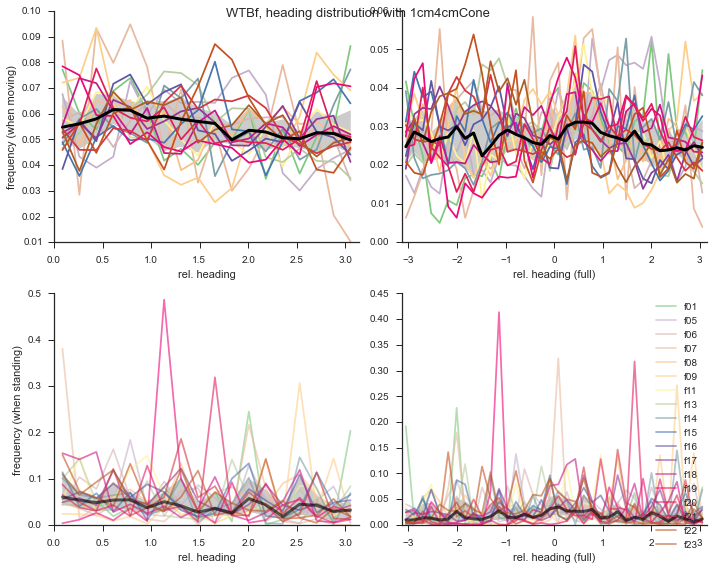

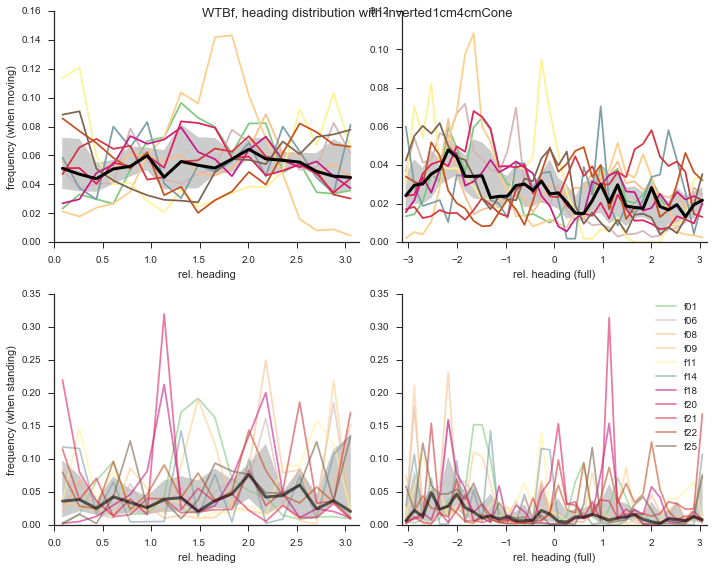

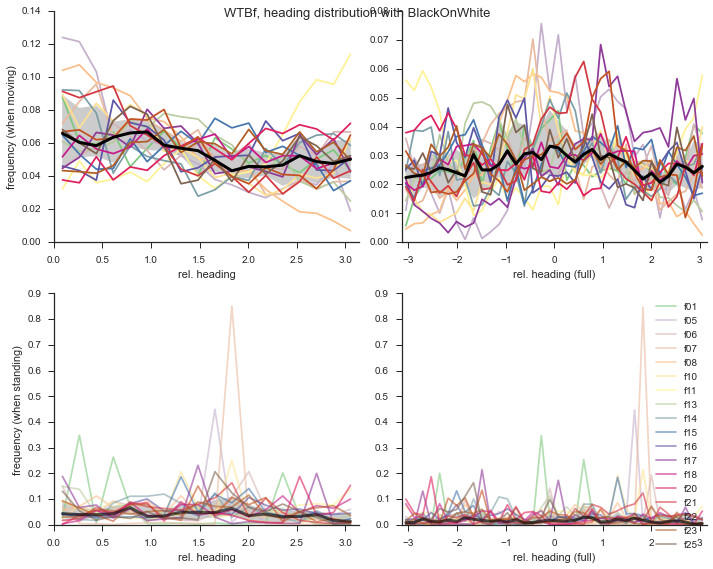

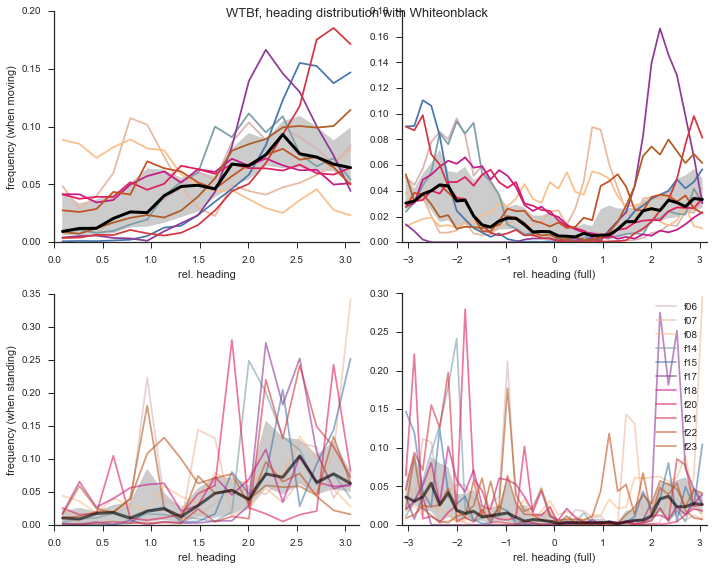

In [592]:
for scene in range(4):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename+'\n')
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag,True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

1cm4cmCone
fly 1 not moving
19.1416666667
fly 2 not moving
16.8083333333
fly 3 not moving
0.0
fly 9 not moving
7.93333333333
fly 11 not moving
17.3833333333
fly 23 not moving
7.08333333333
fly 24 not moving
0.0
inverted1cm4cmCone
fly 1 not moving
0.0
fly 2 not moving
5.08333333333
fly 3 not moving
18.25
fly 4 not moving
12.9416666667
fly 6 not moving
5.59166666667
fly 9 not moving
1.075
fly 11 not moving
10.425
fly 12 not moving
16.475
fly 14 not moving
3.15
fly 15 not moving
11.9416666667
fly 16 not moving
12.3916666667
fly 18 not moving
16.675
fly 22 not moving
0.0
fly 23 not moving
3.59166666667
BlackOnWhite
fly 1 not moving
16.4833333333
fly 2 not moving
10.1083333333
fly 3 not moving
11.4166666667
fly 8 not moving
17.525
fly 11 not moving
19.1416666667
fly 18 not moving
4.525
fly 23 not moving
0.991666666667
Whiteonblack
fly 0 not moving
6.60833333333
fly 1 not moving
0.791666666667
fly 2 not moving
6.00833333333
fly 3 not moving
2.98333333333
fly 4 not moving
6.30833333333
fly 8 

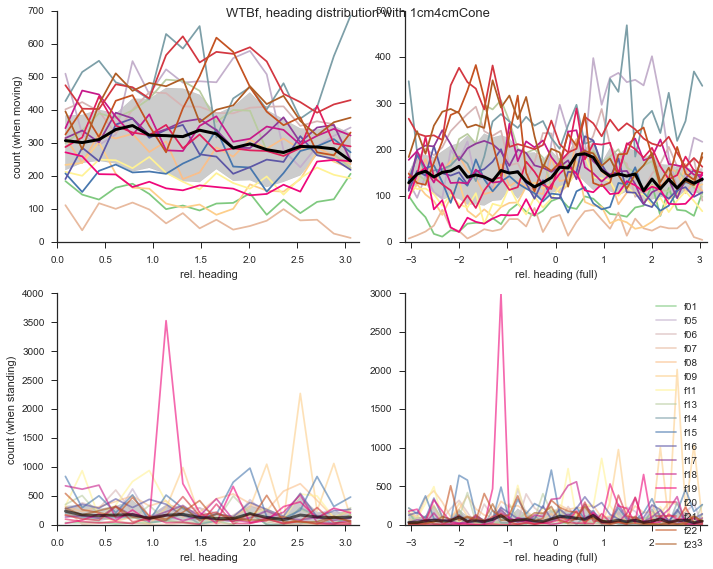

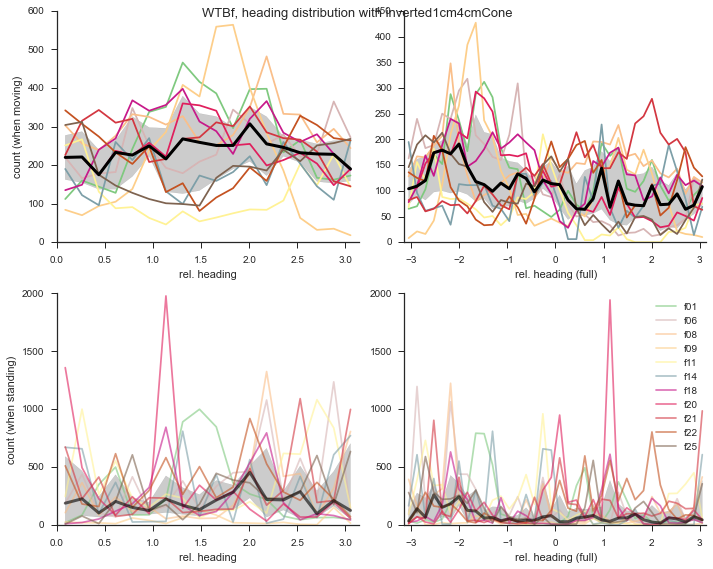

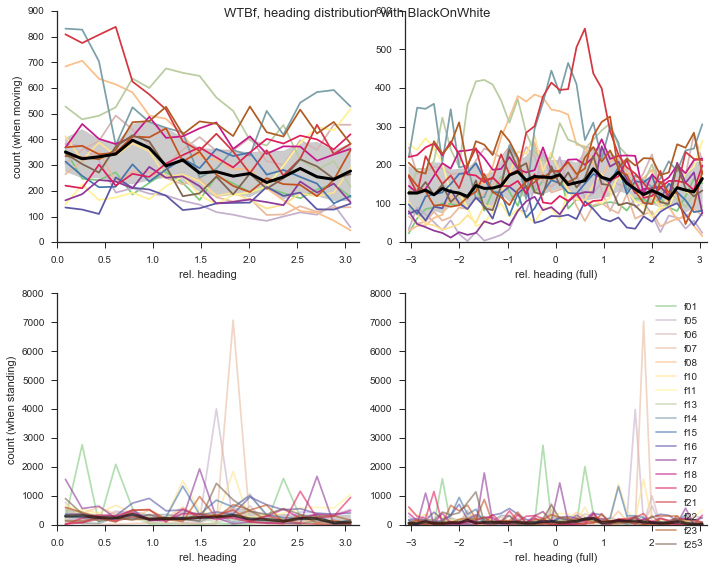

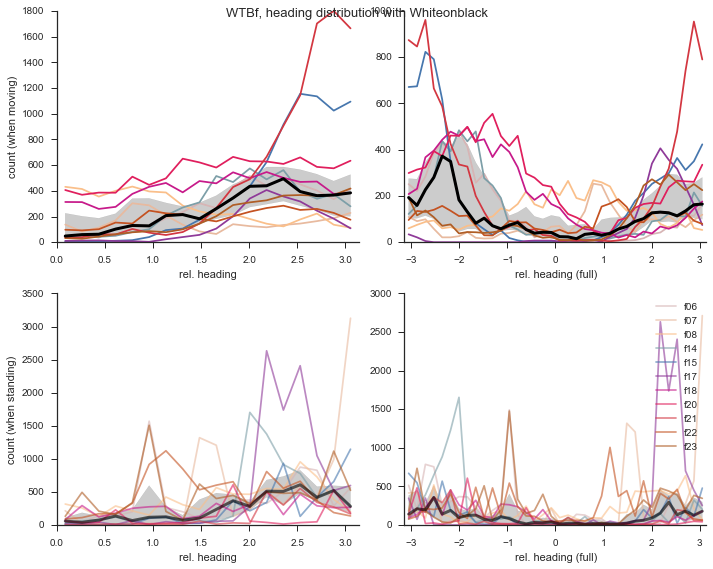

In [593]:
for scene in range(4):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename)
    
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag,True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

In [124]:
def findFixationPeak(N,flySignal):
    maxSignal = np.hstack((np.repeat(flySignal[0],N),flySignal,np.repeat(flySignal[-1],N)))
    maxSignal = np.convolve(maxSignal, np.ones((N,))/N, mode='same')
    maxSignal = maxSignal[N:-N]
    peak = np.where(maxSignal == np.max(maxSignal))[0]
    
    return peak

In [125]:
def findFullWidthHalfMax(y,peak,low):
    #find half maximum
    halfMax = np.median(y)#(y[peak]-y[low])/2.0 + y[low]
    # walk 'downhill' until below half max
    leftW = peak
    rightW = peak
    while(y[leftW]>halfMax):
        leftW = leftW-1
        if(leftW<0):
            leftW = len(y)-1
            
    while(y[rightW]>halfMax):
        rightW = rightW+1
        if(rightW>len(y)-1):
            rightW = 0
        
    return [leftW,rightW]

In [126]:
fullBins = 36
peaks_fullGamma = np.nan*np.ones((4,numFlies,2))
FWHM_fullGamma = np.nan*np.ones((4,numFlies))
densityFlag = True

for scene in range(4):
    scenename = sceneNames[scene]
    print('\n'+scenename+'\n')
    
    for fly in range(numFlies):

        #print(flyIDs[fly])

        querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()

        if sum(moving)<=0.2*len(moving):
            continue

        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=fullBins)
        if densityFlag:
            normFactor = nhead.sum()
        else:
            normFactor = 1.0

        currFlySignal = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        # find peak of heading:
        N=5
        peak = findFixationPeak(N,currFlySignal)
        low = findFixationPeak(N,-1*currFlySignal)
        peak = findFixationPeak(N,currFlySignal)
        peaks_fullGamma[scene,fly,:] = [fulledges[peak],currFlySignal[peak]]
        
        #find FWHM
        [leftW, rightW] = findFullWidthHalfMax(currFlySignal,peak,low)

        FWHM = np.abs((fulledges[rightW]+np.pi)-(fulledges[leftW]+np.pi))
        
        FWHM_fullGamma[scene,fly] = FWHM



1cm4cmCone


inverted1cm4cmCone


BlackOnWhite


Whiteonblack



In [127]:
try:
    mkdir(analysisDir + sep + 'peakAnalysis' + sep)
except OSError:
    print('Analysis directory already exists.')
    
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'peaksLoc_fullGamma.csv', peaks_fullGamma[:,:,0].T,
           fmt="%s", delimiter=',', newline='\n', 
           header='1cm4cmCone, inverted1cm4cmCone, BlackOnWhite, WhiteOnBlack', footer='', comments='# ')
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'peaksSize_fullGamma.csv', peaks_fullGamma[:,:,1].T,
           fmt="%s", delimiter=',', newline='\n', 
           header='1cm4cmCone, inverted1cm4cmCone, BlackOnWhite, WhiteOnBlack', footer='', comments='# ')
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'FWHM_fullGamma.csv', FWHM_fullGamma.T,
           fmt="%s", delimiter=',', newline='\n',
           header='1cm4cmCone, inverted1cm4cmCone, BlackOnWhite, WhiteOnBlack', footer='', comments='# ')

Analysis directory already exists.


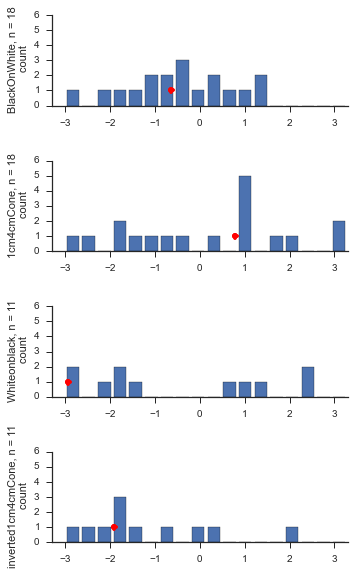

In [128]:
wherePeaksFig = plt.figure(figsize=(5,8))
histRange = (-np.pi, np.pi)
fullHistBins = 18
for sceneind, scene in enumerate([2,0,3,1]):
    scenePlt = wherePeaksFig.add_subplot(4,1,sceneind+1)
    nhead, edges = np.histogram(peaks_fullGamma[scene,~np.isnan(peaks_fullGamma[scene,:,0]),0],range=histRange,bins=fullHistBins)
    scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=1.6*np.pi/fullHistBins)
    nanMask = ~np.isnan(peaks_fullGamma[scene,:,0])
    meanx = np.arctan2(np.median(np.sin(peaks_fullGamma[scene,nanMask,0])),np.median(np.cos(peaks_fullGamma[scene,nanMask,0])));
    scenePlt.plot(meanx,1,'ro')
    sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[scene,:,0]))))
    scenePlt.set_ylabel(sceneNames[scene]+', n = '+sampleSize+'\n count')
    scenePlt.set_xlim(-np.pi*1.05,np.pi*1.05)
    scenePlt.set_ylim(0,6)
    myAxisTheme(scenePlt)
wherePeaksFig.tight_layout()   

wherePeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakLocHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

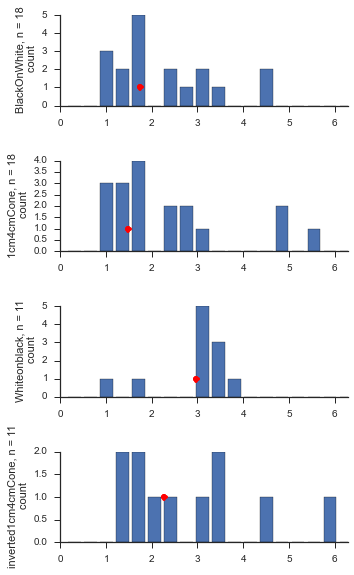

In [129]:
widthPeaksFig = plt.figure(figsize=(5,8))
histRange = (0,2*np.pi)
fullHistBins = 18
for sceneind, scene in enumerate([2,0,3,1]):
    scenePlt = widthPeaksFig.add_subplot(4,1,sceneind+1)
    nhead, edges = np.histogram(FWHM_fullGamma[scene,~np.isnan(FWHM_fullGamma[scene,:])],range=histRange,bins=fullHistBins)
    scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=1.6*np.pi/fullHistBins)
    nanMask = ~np.isnan(FWHM_fullGamma[scene,:])
    meanx = np.median(FWHM_fullGamma[scene,nanMask])
    scenePlt.plot(meanx,1,'ro')
    sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[scene,:,0]))))
    scenePlt.set_ylabel(sceneNames[scene]+', n = '+sampleSize+'\n count')
    scenePlt.set_xlim(0,2*np.pi)
    myAxisTheme(scenePlt)
widthPeaksFig.tight_layout()

widthPeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakWidthHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

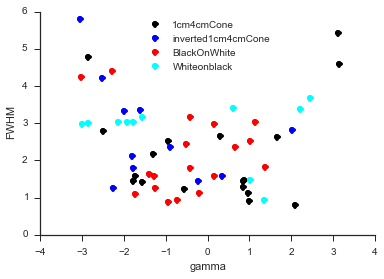

In [130]:
posVsWidth = plt.figure(figsize=(6,4))

posVsWidthPlt = posVsWidth.add_subplot(111)
colcode = ['black','blue','red','cyan']
for scene in range(4):
    posVsWidthPlt.plot(peaks_fullGamma[scene,:,0]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                       FWHM_fullGamma[scene,:]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                       'o',color = colcode[scene])
posVsWidthPlt.legend(sceneNames,loc=9)
posVsWidthPlt.set_xlabel('gamma')
posVsWidthPlt.set_ylabel('FWHM')
myAxisTheme(posVsWidthPlt)

posVsWidth.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakPosVsWidth_n'+str(numFlies)+'.pdf', format = 'pdf')

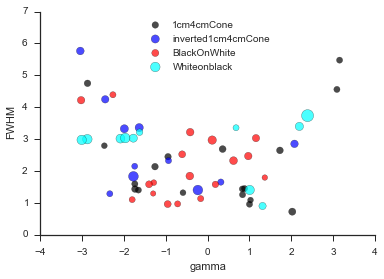

In [131]:
posVsWidth = plt.figure(figsize=(6,4))

posVsWidthPlt = posVsWidth.add_subplot(111)
colcode = ['black','blue','red','cyan']
for scene in range(4):
    posVsWidthPlt.scatter(peaks_fullGamma[scene,:,0]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                          FWHM_fullGamma[scene,:]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                          c=colcode[scene],s=1000*peaks_fullGamma[scene,:,1],alpha=0.7)
posVsWidthPlt.legend(sceneNames,loc=9)
posVsWidthPlt.set_xlabel('gamma')
posVsWidthPlt.set_ylabel('FWHM')
myAxisTheme(posVsWidthPlt)

posVsWidth.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakPosVsWidthPeak_n'+str(numFlies)+'.pdf', format = 'pdf')

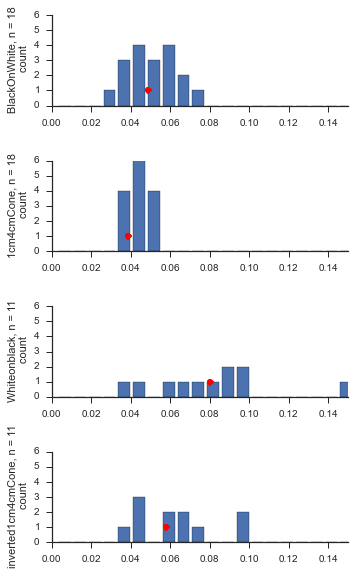

In [132]:
wherePeaksFig = plt.figure(figsize=(5,8))
maxSize = 0.15
histRange = (0,maxSize)
fullHistBins = 20
for sceneind, scene in enumerate([2,0,3,1]):
    scenePlt = wherePeaksFig.add_subplot(4,1,sceneind+1)
    nhead, edges = np.histogram(peaks_fullGamma[scene,~np.isnan(peaks_fullGamma[scene,:,1]),1],range=histRange,bins=fullHistBins)
    scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=0.8*maxSize/fullHistBins)
    nanMask = ~np.isnan(peaks_fullGamma[scene,:,1])
    meanx = np.median(peaks_fullGamma[scene,nanMask,1])
    scenePlt.plot(meanx,1,'ro')
    sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[scene,:,0]))))
    scenePlt.set_ylabel(sceneNames[scene]+', n = '+sampleSize+'\n count')
    scenePlt.set_xlim(0,maxSize)
    scenePlt.set_ylim(0,6)
    myAxisTheme(scenePlt)
wherePeaksFig.tight_layout()   

wherePeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakHeightHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

fly 0 not moving
6.60833333333
fly 1 not moving
0.791666666667
fly 2 not moving
6.00833333333


/Users/hannah/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


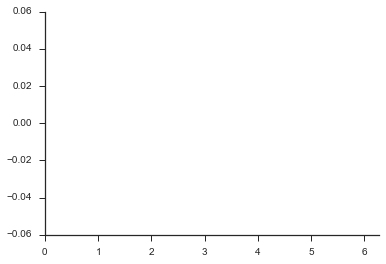

In [521]:
#TEST CODE

testFig = plt.figure()

fullBins = 36
nhead_fullGamma = np.nan*np.ones((numFlies,fullBins))
peaks_fullGamma = np.nan*np.ones((numFlies,2))

gammaPlt = testFig.add_subplot(111)

for fly in range(3):
    
    #print(flyIDs[fly])
    
    querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
    gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

    moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()

    if sum(moving)<=0.2*len(moving):
        print('fly '+str(fly)+' not moving')
        print(100.0*sum(moving)/max(1,len(moving)))
        
        continue

    histRange = (-np.pi, np.pi)
    nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=fullBins)
    gammaPlt.set_xlabel('rel. heading')
    if densityFlag:
        gammaPlt.set_ylabel('frequency (when moving)')
        normFactor = nhead.sum()
    else:
        gammaPlt.set_ylabel('count (when moving)')
        normFactor = 1.0
    gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))

    currFlySignal = nhead/normFactor
    nhead_fullGamma[fly,:] = currFlySignal
    fulledges = edges[:-1]+np.diff(edges)/2
    
    # find peak of heading:
    peak = findFixationPeak(N,currFlySignal)
    low = findFixationPeak(N,-1*currFlySignal)
    
    gammaPlt.plot(fulledges[peak],currFlySignal[peak],'ro')
    gammaPlt.plot(fulledges[low],currFlySignal[low],'bo')
    
    #find half maximum
    [leftW, rightW] = findFullWidthHalfMax(currFlySignal,peak,low)
        
    gammaPlt.plot(fulledges[leftW],currFlySignal[leftW],'go')
    gammaPlt.plot(fulledges[rightW],currFlySignal[rightW],'yo')
    
    FWHM = np.abs(fulledges[rightW]-fulledges[leftW])
    print(FWHM)

    peaks_fullGamma[fly,:] = [fulledges[peak],currFlySignal[peak]]
    
gammaPlt.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:],0),color='k',linewidth=3)
gammaPlt.set_xlim(histRange)
myAxisTheme(gammaPlt)